# KDD Cup 2009

A Administração de Relacionamento com o Consumidor é um elemento-chave das estratégias modernas de marketing. A maneira mais prática de adquirir conhecimento sobre consumidores é produzindo pontuações. Uma pontuação é a saída de um modelo e serve como avaliação de todas as instâncias de uma variável-alvo que se pretenda explicar. Ferramentas que produzem pontuações permitem projetar informações quantificáveis em uma dada população. A pontuação é calculada usando variáveis de entrada que descrevem as instâncias. As pontuações são então usadas pelo sistema de informação, por exemplo, para personalizar o relacionamento com o consumidor.

Em 2009, a conferência Knowledge Discovery and Data Mining (KDD) lançou um desafio envolvendo aprendizagem de máquina. Ela disponibilizou dados de consumidores da empresa de telecomunicações francesa Orange, que deveriam ser utilizados para a construção de um modelo capaz de prever três comportamentos do consumidor. A planilha fornecida tem 50000 instâncias e 230 variáveis, sendo as primeiras 190 variáveis numéricas e as demais 40 categóricas. As variáveis de saída do modelo eram o cancelamento da conta ('churn'), a tendência de usar novos produtos e serviços ('appetency') e a propensão para comprar upgrades ou adicionais com maior margem de lucro quando apresentados (upselling), fornecidos de forma binária (-1 para não, 1 para sim).

O trabalho apresentado aqui envolve a criação de um modelo para predição de churn, appetency e upselling com base nos dados fornecidos dos clientes da Orange. O critério para avaliação do modelo será a métrica AUC, que dimensiona o trade-off entre taxa de falsos positivos e taxa de verdadeiros positivos: quanto mais próximo de 1, menor o trade-off e melhor o modelo.

Detalhes sobre a competição: https://www.kdd.org/kdd-cup/view/kdd-cup-2009

# Etapa 1: Modelando 'churn' (cancelamento da conta)

## Importando as dependências

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
pd.set_option('display.max_columns', 1000)

## Carregando os dados

In [3]:
features = pd.read_csv('C:/Users/johnn/OneDrive/Documentos/Machine Learning/IA Expert/Competição Kaggle/kdd/orange_small_train.data', sep='\t')
outcome = pd.read_csv('C:/Users/johnn/OneDrive/Documentos/Machine Learning/IA Expert/Competição Kaggle/kdd/orange_small_train_churn.labels', sep='\t', header=None)

In [4]:
features

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,Var51,Var52,Var53,Var54,Var55,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var79,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var141,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var167,Var168,Var169,Var170,Var171,Var172,Var173,Var174,Var175,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,NaN,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.0,580.0,NaN,14.0,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3570.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.076907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,35.0,NaN,1350864.0,NaN,0.0,NaN,NaN,7333.11,NaN,5.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,NaN,NaN,168.0,117625.60,NaN,NaN,NaN,NaN,NaN,1175.0,NaN,NaN,NaN,6.0,NaN,720.0,8.0,NaN,NaN,NaN,NaN,NaN,0.0,1212385.0,69134.0,NaN,NaN,NaN,NaN,NaN,185.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,397579.0,NaN,NaN,NaN,1812252.0,NaN,NaN,NaN,NaN,NaN,NaN,142.0,NaN,NaN,38418.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,462.0,NaN,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,210.0,NaN,2.0,24.0,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4764966.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.408032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,26,0.0,NaN,2872928.0,NaN,3.0,NaN,NaN,151098.90,NaN,25.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,40.0,-356411.60,NaN,NaN,NaN,NaN,NaN,590.0,NaN,NaN,NaN,72.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,4136430.0,357038.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,278334.0,NaN,NaN,NaN,10439160.0,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,238572.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,NaN,NaN,904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212.0,1515.0,NaN,26.0,816.0,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5883894.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.599658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130,518.0,NaN,1675

In [5]:
features.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,Var51,Var52,Var53,Var54,Var55,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var79,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var141,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var167,Var168,Var169,Var170,Var171,Var172,Var173,Var174,Var175,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,NaN,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.0,580.0,NaN,14.0,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3570.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.076907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,35.0,NaN,1350864.0,NaN,0.0,NaN,NaN,7333.11,NaN,5.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,NaN,NaN,168.0,117625.60,NaN,NaN,NaN,NaN,NaN,1175.0,NaN,NaN,NaN,6.0,NaN,720.0,8.0,NaN,NaN,NaN,NaN,NaN,0.0,1212385.0,69134.0,NaN,NaN,NaN,NaN,NaN,185.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,397579.0,NaN,NaN,NaN,1812252.0,NaN,NaN,NaN,NaN,NaN,NaN,142.0,NaN,NaN,38418.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,462.0,NaN,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,210.0,NaN,2.0,24.0,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4764966.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.408032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,26,0.0,NaN,2872928.0,NaN,3.0,NaN,NaN,151098.90,NaN,25.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,40.0,-356411.60,NaN,NaN,NaN,NaN,NaN,590.0,NaN,NaN,NaN,72.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,4136430.0,357038.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,278334.0,NaN,NaN,NaN,10439160.0,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,238572.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,NaN,NaN,904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212.0,1515.0,NaN,26.0,816.0,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5883894.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.599658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130,518.0,NaN,1675

In [6]:
outcome.head()

,0
0,-1
1,1
2,-1
3,-1
4,-1


In [7]:
np.unique(outcome)

array([-1,  1], dtype=int64)

## Identificando Variaveis

In [8]:
all_vars = np.array(features.columns)
all_vars

array(['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8',
       'Var9', 'Var10', 'Var11', 'Var12', 'Var13', 'Var14', 'Var15',
       'Var16', 'Var17', 'Var18', 'Var19', 'Var20', 'Var21', 'Var22',
       'Var23', 'Var24', 'Var25', 'Var26', 'Var27', 'Var28', 'Var29',
       'Var30', 'Var31', 'Var32', 'Var33', 'Var34', 'Var35', 'Var36',
       'Var37', 'Var38', 'Var39', 'Var40', 'Var41', 'Var42', 'Var43',
       'Var44', 'Var45', 'Var46', 'Var47', 'Var48', 'Var49', 'Var50',
       'Var51', 'Var52', 'Var53', 'Var54', 'Var55', 'Var56', 'Var57',
       'Var58', 'Var59', 'Var60', 'Var61', 'Var62', 'Var63', 'Var64',
       'Var65', 'Var66', 'Var67', 'Var68', 'Var69', 'Var70', 'Var71',
       'Var72', 'Var73', 'Var74', 'Var75', 'Var76', 'Var77', 'Var78',
       'Var79', 'Var80', 'Var81', 'Var82', 'Var83', 'Var84', 'Var85',
       'Var86', 'Var87', 'Var88', 'Var89', 'Var90', 'Var91', 'Var92',
       'Var93', 'Var94', 'Var95', 'Var96', 'Var97', 'Var98', 'Var99',
       'Var100', 'Va

In [9]:
num_vars = np.array(all_vars[:190])
num_vars

array(['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8',
       'Var9', 'Var10', 'Var11', 'Var12', 'Var13', 'Var14', 'Var15',
       'Var16', 'Var17', 'Var18', 'Var19', 'Var20', 'Var21', 'Var22',
       'Var23', 'Var24', 'Var25', 'Var26', 'Var27', 'Var28', 'Var29',
       'Var30', 'Var31', 'Var32', 'Var33', 'Var34', 'Var35', 'Var36',
       'Var37', 'Var38', 'Var39', 'Var40', 'Var41', 'Var42', 'Var43',
       'Var44', 'Var45', 'Var46', 'Var47', 'Var48', 'Var49', 'Var50',
       'Var51', 'Var52', 'Var53', 'Var54', 'Var55', 'Var56', 'Var57',
       'Var58', 'Var59', 'Var60', 'Var61', 'Var62', 'Var63', 'Var64',
       'Var65', 'Var66', 'Var67', 'Var68', 'Var69', 'Var70', 'Var71',
       'Var72', 'Var73', 'Var74', 'Var75', 'Var76', 'Var77', 'Var78',
       'Var79', 'Var80', 'Var81', 'Var82', 'Var83', 'Var84', 'Var85',
       'Var86', 'Var87', 'Var88', 'Var89', 'Var90', 'Var91', 'Var92',
       'Var93', 'Var94', 'Var95', 'Var96', 'Var97', 'Var98', 'Var99',
       'Var100', 'Va

In [10]:
cat_vars = np.array(all_vars[190:])
cat_vars

array(['Var191', 'Var192', 'Var193', 'Var194', 'Var195', 'Var196',
       'Var197', 'Var198', 'Var199', 'Var200', 'Var201', 'Var202',
       'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208',
       'Var209', 'Var210', 'Var211', 'Var212', 'Var213', 'Var214',
       'Var215', 'Var216', 'Var217', 'Var218', 'Var219', 'Var220',
       'Var221', 'Var222', 'Var223', 'Var224', 'Var225', 'Var226',
       'Var227', 'Var228', 'Var229', 'Var230'], dtype=object)

### Verificação a consistências das variáveis

In [11]:
features.iloc[:,:190].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 190 entries, Var1 to Var190
dtypes: float64(189), int64(1)
memory usage: 72.5 MB


In [12]:
features.iloc[:,190:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Var191  1083 non-null   object 
 1   Var192  49631 non-null  object 
 2   Var193  50000 non-null  object 
 3   Var194  12784 non-null  object 
 4   Var195  50000 non-null  object 
 5   Var196  50000 non-null  object 
 6   Var197  49857 non-null  object 
 7   Var198  50000 non-null  object 
 8   Var199  49996 non-null  object 
 9   Var200  24592 non-null  object 
 10  Var201  12783 non-null  object 
 11  Var202  49999 non-null  object 
 12  Var203  49857 non-null  object 
 13  Var204  50000 non-null  object 
 14  Var205  48066 non-null  object 
 15  Var206  44471 non-null  object 
 16  Var207  50000 non-null  object 
 17  Var208  49857 non-null  object 
 18  Var209  0 non-null      float64
 19  Var210  50000 non-null  object 
 20  Var211  50000 non-null  object 
 21  Var212  50000 non-null  object 
 22

In [13]:
features['Var209'].value_counts()

Series([], Name: count, dtype: int64)

In [14]:
features = features.replace('', np.nan)

In [15]:
features.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,Var51,Var52,Var53,Var54,Var55,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var79,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var141,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var167,Var168,Var169,Var170,Var171,Var172,Var173,Var174,Var175,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,NaN,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.0,580.0,NaN,14.0,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3570.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.076907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,35.0,NaN,1350864.0,NaN,0.0,NaN,NaN,7333.11,NaN,5.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,NaN,NaN,168.0,117625.60,NaN,NaN,NaN,NaN,NaN,1175.0,NaN,NaN,NaN,6.0,NaN,720.0,8.0,NaN,NaN,NaN,NaN,NaN,0.0,1212385.0,69134.0,NaN,NaN,NaN,NaN,NaN,185.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,397579.0,NaN,NaN,NaN,1812252.0,NaN,NaN,NaN,NaN,NaN,NaN,142.0,NaN,NaN,38418.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,462.0,NaN,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,210.0,NaN,2.0,24.0,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4764966.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.408032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,26,0.0,NaN,2872928.0,NaN,3.0,NaN,NaN,151098.90,NaN,25.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,40.0,-356411.60,NaN,NaN,NaN,NaN,NaN,590.0,NaN,NaN,NaN,72.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,4136430.0,357038.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,278334.0,NaN,NaN,NaN,10439160.0,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,238572.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,NaN,NaN,904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212.0,1515.0,NaN,26.0,816.0,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5883894.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.599658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130,518.0,NaN,1675

In [16]:
for col in num_vars:
    features[col] = features[col].astype('float')
for col in cat_vars:
    features[col] = features[col].astype('category')

In [17]:
features.iloc[:,:190].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 190 entries, Var1 to Var190
dtypes: float64(190)
memory usage: 72.5 MB


In [18]:
features.iloc[:,190:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Var191  1083 non-null   category
 1   Var192  49631 non-null  category
 2   Var193  50000 non-null  category
 3   Var194  12784 non-null  category
 4   Var195  50000 non-null  category
 5   Var196  50000 non-null  category
 6   Var197  49857 non-null  category
 7   Var198  50000 non-null  category
 8   Var199  49996 non-null  category
 9   Var200  24592 non-null  category
 10  Var201  12783 non-null  category
 11  Var202  49999 non-null  category
 12  Var203  49857 non-null  category
 13  Var204  50000 non-null  category
 14  Var205  48066 non-null  category
 15  Var206  44471 non-null  category
 16  Var207  50000 non-null  category
 17  Var208  49857 non-null  category
 18  Var209  0 non-null      category
 19  Var210  50000 non-null  category
 20  Var211  50000 non-null  category
 21  Var212  5000

## Seleção de Variáveis

### Variáveis com muitos valores faltantes

In [19]:
features.shape

(50000, 230)

In [20]:
features[num_vars].isnull().sum()

Var1      49298
Var2      48759
Var3      48760
Var4      48421
Var5      48513
          ...  
Var186    49298
Var187    49298
Var188    48759
Var189    28978
Var190    49667
Length: 190, dtype: int64

In [21]:
features[cat_vars].isnull().sum()

Var191    48917
Var192      369
Var193        0
Var194    37216
Var195        0
Var196        0
Var197      143
Var198        0
Var199        4
Var200    25408
Var201    37217
Var202        1
Var203      143
Var204        0
Var205     1934
Var206     5529
Var207        0
Var208      143
Var209    50000
Var210        0
Var211        0
Var212        0
Var213    48871
Var214    25408
Var215    49306
Var216        0
Var217      703
Var218      703
Var219     5211
Var220        0
Var221        0
Var222        0
Var223     5211
Var224    49180
Var225    26144
Var226        0
Var227        0
Var228        0
Var229    28432
Var230    50000
dtype: int64

In [22]:
empty_entries_per_column = features.isna().sum(axis=0)

In [23]:
empty_entries_per_column

Var1      49298
Var2      48759
Var3      48760
Var4      48421
Var5      48513
          ...  
Var226        0
Var227        0
Var228        0
Var229    28432
Var230    50000
Length: 230, dtype: int64

48513.0


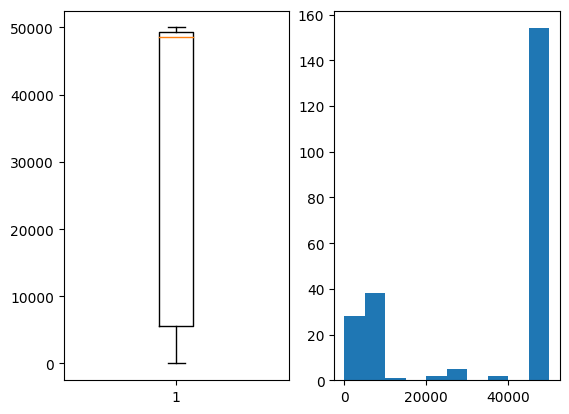

In [24]:
fig, (axis1, axis2) = plt.subplots(1, 2)
axis1.boxplot(empty_entries_per_column)
axis2.hist(empty_entries_per_column)
median = empty_entries_per_column.median()
print(median)


In [25]:
num_entries = len(features)
threshold = 0.25

num_entries * threshold

12500.0

In [26]:
keep_vars = np.array(features.columns[(empty_entries_per_column <= (num_entries * threshold))])
keep_vars

array(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25',
       'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73',
       'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109',
       'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var132',
       'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149',
       'Var153', 'Var160', 'Var163', 'Var173', 'Var181', 'Var192',
       'Var193', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199',
       'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207',
       'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var217',
       'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223',
       'Var226', 'Var227', 'Var228'], dtype=object)

In [27]:
num_vars = [elem for elem in num_vars if elem in keep_vars]
cat_vars = [elem for elem in cat_vars if elem in keep_vars]

In [28]:
len(num_vars), len(cat_vars)

(38, 28)

In [29]:
for col in num_vars:
    col_mean = features[col].mean()
    features[col] = features[col].fillna(col_mean)

In [30]:
for col in cat_vars:
    features[col] = features[col].cat.add_categories('missing')
    features[col] = features[col].fillna('missing')

### Varáveis categoricas com muitas categorias

In [31]:
n_categories_per_feature = features[cat_vars].apply(lambda x: len(x.unique()))
n_categories_per_feature

Var192      362
Var193       51
Var195       23
Var196        4
Var197      226
Var198     4291
Var199     5074
Var202     5714
Var203        6
Var204      100
Var205        4
Var206       22
Var207       14
Var208        3
Var210        6
Var211        2
Var212       81
Var216     2016
Var217    13991
Var218        3
Var219       23
Var220     4291
Var221        7
Var222     4291
Var223        5
Var226       23
Var227        7
Var228       30
dtype: int64

(array([21.,  1.,  0.,  4.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([2.00000e+00, 1.40090e+03, 2.79980e+03, 4.19870e+03, 5.59760e+03,
        6.99650e+03, 8.39540e+03, 9.79430e+03, 1.11932e+04, 1.25921e+04,
        1.39910e+04]),
 <BarContainer object of 10 artists>)

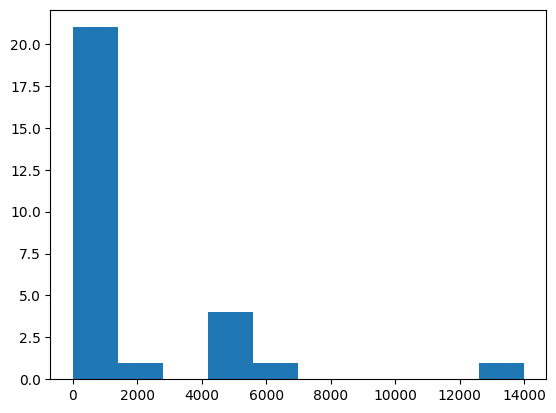

In [32]:
plt.hist(n_categories_per_feature)

In [33]:
cat_vars = np.array(n_categories_per_feature[n_categories_per_feature < 1500].index)
cat_vars

array(['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var203',
       'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210',
       'Var211', 'Var212', 'Var218', 'Var219', 'Var221', 'Var223',
       'Var226', 'Var227', 'Var228'], dtype=object)

In [34]:
len(cat_vars)

21

In [35]:
features = pd.concat(objs=[features[num_vars], features[cat_vars]], axis=1)

In [36]:
features

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var57,Var65,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var109,Var112,Var113,Var119,Var123,Var125,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var192,Var193,Var195,Var196,Var197,Var203,Var204,Var205,Var206,Var207,Var208,Var210,Var211,Var212,Var218,Var219,Var221,Var223,Var226,Var227,Var228
0,1526.000000,7.000000,184.000000,464.000000,580.000000,14.000000,128.00000,166.560000,0.00000,3.570000e+03,0.000000,4.076907,9.000000,36.0,35.000000,1.350864e+06,0.000000,7333.110000,5.00000,12.000000,104.00000,168.000000,117625.60,1175.000000,6.000000,720.000000,0.000000,1.212385e+06,69134.000000,185.000000,0.000000,9.000000,397579.000000,1.812252e+06,142.000000,38418.000000,0.000000,0.000000,bZkvyxLkBI,RO12,taul,1K8T,lK27,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,uKAI,L84s,XfqtO3UdzaXh_,cJvF,FzaX,oslk,jySVZNlOJy,xb3V,RAYp,F2FyR07IdsN7I
1,525.000000,0.000000,0.000000,168.000000,210.000000,2.000000,24.00000,353.520000,0.00000,4.764966e+06,0.000000,5.408032,9.000000,26.0,0.000000,2.872928e+06,3.000000,151098.900000,25.00000,2.000000,40.00000,40.000000,-356411.60,590.000000,72.000000,0.000000,8.000000,4.136430e+06,357038.000000,0.000000,0.000000,9.000000,278334.000000,1.043916e+07,32.000000,238572.000000,0.000000,0.000000,CEat0G8rTN,RO12,taul,1K8T,2Ix5,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,uKAI,L84s,NhsEn4L,missing,FzaX,oslk,LM8l689qOp,fKCe,RAYp,F2FyR07IdsN7I
2,5236.000000,7.000000,904.000000,1212.000000,1515.000000,26.000000,816.00000,220.080000,0.00000,5.883894e+06,0.000000,6.599658,9.000000,130.0,518.000000,1.675776e+06,0.000000,16211.580000,40.00000,58.000000,312.00000,336.000000,405104.00,3230.000000,114.000000,5967.000000,0.000000,3.478905e+06,248932.000000,800.000000,0.000000,36.000000,320565.000000,9.826360e+06,206.000000,434946.000000,0.000000,0.000000,eOQt0GoOh3,AERks4l,taul,1K8T,ffXs,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,uKAI,L84s,UbxQ8lZ,UYBR,FzaX,Al6ZaUT,jySVZNlOJy,Qu4f,02N6s8f,ib5G6X1eUxUn6
3,1326.437116,0.000000,0.000000,234.518225,0.000000,4.507926,0.00000,22.080000,0.00000,0.000000e+00,0.000000,1.988250,9.000000,12.0,0.000000,0.000000e+00,0.000000,103084.052693,0.00000,0.000000,60.88866,0.000000,-275703.60,916.112185,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,11.727665,294920.804255,0.000000e+00,0.000000,0.000000,0.000000,0.000000,jg69tYsGvO,RO12,taul,1K8T,ssAy,9_Y1,YULl,VpdQ,missing,me75fM6ugJ,kIsH,uKAI,Mtgm,NhsEn4L,UYBR,FzaX,oslk,LM8l689qOp,FSa2,RAYp,F2FyR07IdsN7I
4,1029.000000,7.000000,3216.000000,64.000000,80.000000,4.000000,64.00000,200.000000,0.00000,0.000000e+00,0.000000,4.552446,18.000000,82.0,224.000000,7.844480e+05,0.000000,37423.500000,0.00000,0.000000,32.00000,56.000000,10714.84,215.000000,0.000000,15111.000000,0.000000,1.506500e+05,66046.000000,3255.000000,0.000000,9.000000,267162.000000,6.448360e+05,2.000000,0.000000,0.000000,0.000000,IXSgUHShse,RO12,taul,1K8T,uNkU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,uKAI,L84s,XfqtO3UdzaXh_,UYBR,FzaX,oslk,LM8l689qOp,FSa2,RAYp,F2FyR07IdsN7I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,357.000000,0.000000,0.000000,132.000000,165.000000,2.000000,0.00000,288.080000,0.00000,6.042420e+06,0.000000,2.757958,27.000000,22.0,0.000000,2.764800e+06,0.000000,219451.200000,20.00000,0.000000,32.00000,32.000000,85899.60,510.000000,84.000000,0.000000,0.000000,4.467425e+06,0.000000,0.000000,0.000000,9.000000,604800.000000,1.036704e+07,22.000000,0.000000,0.000000,0.000000,xOXr4RXktW,RO12,taul,1K8T,ZNsX,9_Y1,ZKJc,VpdQ,zm5i,me75fM6ugJ,kIsH,uKAI,L84s,NhsEn4L,cJvF,FzaX,oslk,LM8l689qOp,7FJQ,RAYp,F2FyR07IdsN7I
49996,1078.000000,0.000000,2736.000000,380.000000,475.000000,2.000000,88.00000,166.560000,0.00000,0.000000e+00,0.000000,0.594958,27.000000,132.0,420.000000,2.243440e+

### Seleção de variáveis baseada em árvore de decisão

In [37]:
features_c = pd.get_dummies(features, drop_first=True, dtype='int')

In [38]:
features_c.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var57,Var65,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var109,Var112,Var113,Var119,Var123,Var125,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var192_0kQTmBU3gb,Var192_0kQqrQsiZt,Var192_0vimfo8zhV,Var192_1GdOj17ejg,Var192_1GdOj1KXzC,Var192_1JGTmBQZiT,Var192_1JGqrQKzJV,Var192_1JGr4RKzJV,Var192_1JGr4RUaLY,Var192_1KSTmBQxul,Var192_1KSqrQK2Mx,Var192_1KSr4RK2Mx,Var192_1PnOj1KVEH,Var192_1PnZptzip9,Var192_1YVTmBftjz,Var192_1YVgUHXZeb,Var192_1YVvyx7IEC,Var192_1fZWq6e2Rv,Var192_1fZWq6wFxs,Var192_1nlTmBtueT,Var192_1qmgUHEuty,Var192_1qmr4RQxul,Var192_25_t0Gdncc,Var192_2AAWq69R_D,Var192_2AArEyQtC3,Var192_2jfvyxUZHQ,Var192_2jiWq69cTy,Var192_2jiWq6IuZZ,Var192_2jigUH7ejg,Var192_2jirEyXktW,Var192_302Oj17IEC,Var192_302Oj1KVEH,Var192_31rTmBtueT,Var192_3HjOj17ejg,Var192_4E_Oj1siQ3,Var192_4bwt0GoOh3,Var192_4e7Wq69R_D,Var192_4e7gUH7IEC,Var192_4e7rEyXXnK,Var192_51rBcmz45j,Var192_51rt0G8rTN,Var192_52Iq9ayE15,Var192_5_lq9aXt5a,Var192_5_lq9at_88,Var192_639TmBQxul,Var192_639qrQK2Mx,Var192_639r4RK2Mx,Var192_64nWq69R_D,Var192_64ngUH7IEC,Var192_64ngUH8rdT,Var192_64nrEyXXnK,Var192_6VLgUHQicn,Var192_6VLvyx7IEC,Var192_6m0t0G8rTN,Var192_6m0t0GVP8g,Var192_6z9r4Rdc_a,Var192_75lTmBtFkL,Var192_75lq9ayfAo,Var192_75lr4RQ13H,Var192_75lr4RXktW,Var192_7Cwt0Gdc_a,Var192_7fxgUHdtN_,Var192_7whOj1scCA,Var192_7zYrEyQ13H,Var192_86ct0Gdncc,Var192_8Fdr4RXXnK,Var192_8I1TmB9iKe,Var192_8I1TmBtueT,Var192_8I1q9ayE15,Var192_8I1r4RXXnK,Var192_8Iqt0G8rTN,Var192_8Knvyx875g,Var192_9hRmfo875g,Var192_9rAq9at_88,Var192_9rArjIQ_vI,Var192_9u0r4Rdncc,Var192_AKDq9ayfAo,Var192_AKDr4RXktW,Var192_AUUt0GoOh3,Var192_AhzOj17IEC,Var192_AhzZptzip9,Var192_B2DgUHdMWg,Var192_BQa9tYsdof,Var192_BQavyxLp3Z,Var192_BQavyxsiQ3,Var192_BSxr4R4FLE,Var192_C2Dvyx875g,Var192_CEaBcmz45j,Var192_CEaWq69cTy,Var192_CEaWq6KZjV,Var192_CEat0G8rTN,Var192_CxSr4RXktW,Var192_DHeTmBftjz,Var192_DHegUHXZeb,Var192_DHeq9ayfAo,Var192_DHerjIKQ76,Var192_DHevyx7IEC,Var192_DOvgUHXZeb,Var192_DOvq9ayfAo,Var192_DOvrjIKQ76,Var192_DQlWq6IHzm,Var192_DQlgUH7IEC,Var192_DQlrEyXXnK,Var192_E2Yq9atbb6,Var192_E3dr4RQxul,Var192_EGPvyxTlru,Var192_E_tZptzyxY,Var192_EsYq9aX0Db,Var192_EsYq9atbb6,Var192_EsYrjIX0Db,Var192_F42vyxTlru,Var192_FAJWq69cTy,Var192_FAJgUH7ejg,Var192_FAJrEyXktW,Var192_FoxgUHSK8h,Var192_Foxt0Go8Lb,Var192_Gb9t0GQ5Yy,Var192_GcUBcmz45j,Var192_GcUt0G8rTN,Var192_H1Fr4Rdncc,Var192_H7er4Rdc_a,Var192_HAoOj1KXzC,Var192_HOvt0Go8Lb,Var192_HXwt0G8EIb,Var192_HYTgUHXM47,Var192_HYTrEywWJe,Var192_HYTrjIK12c,Var192_HYTvyx7ejg,Var192_HrWq9aXt5a,Var192_HrWrjIXt5a,Var192_IXSgUHShse,Var192_IXSt0GoOh3,Var192_Ie5gUH7IEC,Var192_Ie5rEyQtC3,Var192_Iskvyx875g,Var192_J9Vr4RQZiT,Var192_JJYvyx875g,Var192_JMGq9aXt5a,Var192_JMGq9at_88,Var192_JMGrjIXt5a,Var192_KXMWq69R_D,Var192_KXMgUH7IEC,Var192_KXMgUHdtN_,Var192_KXMrEyXXnK,Var192_LDPTmBftjz,Var192_LDPgUHXZeb,Var192_LDPq9ayfAo,Var192_LDPrjIswVc,Var192_LDPvyx7IEC,Var192_LDPvyxdtN_,Var192_LFvrjIX0Db,Var192_M5vt0Gdc_a,Var192_MfKrEyQtC3,Var192_MlYvyx875g,Var192_MtpBcmzkzH,Var192_Mtpt0G8EIb,Var192_MwmgUHShse,Var192_NESBcmRZ57,Var192_NESWq69R_D,Var192_NESWq6IHzm,Var192_NESt0G8EIb,Var192_NFqq9at_88,Var192_NQ5rEy7Rm6,Var192_NQ5vyxLkBI,Var192_N_vrjIXt5a,Var192_O5Qmfo875g,Var192_O8Zr4Rdc_a,Var192_OaayEZXAPM,Var192_OdsvyxMDH2,Var192_P1WvyxLp3Z,Var192_PRKa6ZegII,Var192_Qu0TmBQZiT,Var192_Qu0qrQKzJV,Var192_Qu0r4RKzJV,Var192_Qu0r4RUaLY,Var192_RzPTmBQZiT,Var192_RzPqrQKzJV,Var192_S8dr4RPoRw,Var192_S8dr4RQxul,Var192_T1hBcmzkzH,Var192_TInyyjFXFX,Var192_TfiBcmzkzH,Var192_TfiWq69R_D,Var192_Tfit0G8EIb,Var192_UCDvyx8zhV,Var192_UOyq9atbb6,Var192_UzE54NEjuC,Var192_V8lBcmz45j,Var192_V8lt0G8rTN,Var192_VvRt0GoOh3,Var192_X9zgUHShse,Var192_Y3tqrQKzJV,Var192_YQqt0GQFLG,Var192_YddTmBtueT,Var192_Yddq9ayE15,Var192_Yddr4R4FLE,Var192_YddrjIQ5Ph,Var192_Ylct0GoOh3,Var192_Yn7gUHf2Df,Var192_Yn7t0Go8Lb,Var192_Ys9q9aQ6UK,Var192_ZCNZptRvgr,Var192_ZSNq9aX0Db,Var192_ZSNq9atbb6,Var192_ZSNrjIX0Db,Var192_ZlOBLJED1x,Var192__hrvyxM6OP,Var192__v2TmBftjz,Var192__v2g

In [39]:
np.array(outcome).ravel()

array([-1,  1, -1, ..., -1, -1, -1], dtype=int64)

In [40]:
def etc_importances(features, outcome):
    model = ExtraTreesClassifier(n_estimators=200, criterion='entropy', verbose=False)
    model.fit(features, np.array(outcome).ravel())
    
    importances = model.feature_importances_
    variables = np.array(features.columns)
    indices = np.argsort(importances)[::-1]
    importances = importances[indices]
    variables = variables[indices]
    
    return variables, importances

In [42]:
variables, importances = etc_importances(features_c, outcome)

In [43]:
variables, importances

(array(['Var57', 'Var73', 'Var113', ..., 'Var197_kOrz', 'Var197_sPdS',
        'Var197_AuRO'], dtype=object),
 array([0.01892703, 0.01823439, 0.01800502, ..., 0.        , 0.        ,
        0.        ]))

In [44]:
df = pd.DataFrame(importances, ).T

In [45]:
df.columns = variables

In [46]:
df

,Var57,Var73,Var113,Var153,Var81,Var133,Var38,Var28,Var76,Var134,Var6,Var123,Var119,Var22,Var163,Var21,Var160,Var25,Var112,Var149,Var83,Var85,Var109,Var125,Var24,Var13,Var144,Var140,Var7,Var65,Var74,Var205_VpdQ,Var218_cJvF,Var218_missing,Var205_sJzTlal,Var211_Mtgm,Var132,Var219_FzaX,Var197_lK27,Var206_IYzP,Var197_TyGl,Var223_jySVZNlOJy,Var197_487l,Var35,Var78,Var197_JLbT,Var226_FSa2,Var219_missing,Var223_missing,Var181,Var197_0Xwj,Var206_zm5i,Var212_NhsEn4L,Var208_sBgB,Var226_Qu4f,Var226_WqMG,Var206_sYC_,Var197_ssAy,Var228_F2FyR07IdsN7I,Var193_RO12,Var205_missing,Var223_M_8D,Var210_uKAI,Var203_HLqf,Var226_fKCe,Var210_g5HH,Var203_F3hy,Var226_Aoh3,Var226_szEZ,Var212_XfqtO3UdzaXh_,Var206_missing,Var226_453m,Var204_k13i,Var206_43pnToF,Var226_5Acm,Var226_7P5s,Var204_RVjC,Var226_xb3V,Var204_m_h1,Var226_Qcbd,Var219_qxDb,Var195_taul,Var204__xpN,Var206_hAFG,Var207_me75fM6ugJ,Var204_rGJy,Var206_wMei,Var226_PM2D,Var206_haYg,Var204_7WNq,Var226_uWr3,Var204_DtNL,Var226_rgKb,Var204_vzJD,Var204_z5Ry,Var204_MBhA,Var143,Var227_RAYp,Var197_z32l,Var44,Var204_15m3,Var219_AU8pNoi,Var204_e7QV,Var204_SkZj,Var221_oslk,Var226_TNEC,Var207_7M47J5GA0pTYIFxg5uy,Var204_mTeA,Var204_TjV7,Var228_55YFVY9,Var204_xQ2A,Var227_ZI9m,Var197_PGNs,Var204_4N0K,Var219_OFWH,Var196_z3mO,Var204_STGZ,Var226_Xa3G,Var204_X8zP,Var204_Y9Bl,Var204_YULl,Var226_7aLG,Var197_2Ix5,Var197_kNzO,Var204_Px52,Var226_kwS7,Var192_2jigUH7ejg,Var197_7gSz,Var197_4fje,Var192_missing,Var206_kxE9,Var204_RcM7,Var197_EJC9,Var204_t_4G,Var226_wX53,Var221_zCkv,Var197_PbOJ,Var204_LqKm,Var204_FbIm,Var192_oyGrjIXt5a,Var204__48V,Var206_Tkho,Var173,Var204_C6Eu,Var204_vm5R,Var192_kMJt0GoOh3,Var192_J9Vr4RQZiT,Var192_dRaTmBfHUn,Var206_6JmL,Var197_OTVu,Var195_LfvqpCtLOY,Var192_FoxgUHSK8h,Var193_AERks4l,Var197_wOc1,Var204_1Bp0,Var204_WGOH,Var204_6TCl,Var204_jdbz,Var197_AnrR,Var192_LDPvyx7IEC,Var204_TFSW,Var192_cFHt0GoOh3,Var206_lVqb,Var204_Z5OU,Var197_pGTb,Var207_DHn_WUyBhW_whjA88g9bvA64_,Var204_F_Lu,Var197_YVv3,Var192_DQlrEyXXnK,Var192_dRarjIK12c,Var204_qaiO,Var192_uUdt0G8EIb,Var192_dTGmfo8zhV,Var192_Foxt0Go8Lb,Var192_NQ5vyxLkBI,Var192_zC_Wq6e2Rv,Var197_LloI,Var192_qFpmfo8zhV,Var192_4e7gUH7IEC,Var226_me1d,Var197_TLkP,Var204_kJJ7,Var197_AHgj,Var192_8I1r4RXXnK,Var192_0vimfo8zhV,Var204_AKLO,Var192_oBXq9ayfAo,Var192_wRXmfo875g,Var226_7FJQ,Var197_hM6W,Var204_KubS,Var192_avkq9ayfAo,Var204_6Kw9,Var192_HYTrjIK12c,Var197_hAOr,Var197_tXti,Var204_0A_v,Var192_75lq9ayfAo,Var204_gnEy,Var192_2jiWq69cTy,Var204_iVbl,Var192_JMGq9aXt5a,Var192_xearjIX0Db,Var192_8Iqt0G8rTN,Var192_Yn7t0Go8Lb,Var204_MGOA,Var197_72yt,Var197_yMvB,Var192_ZSNrjIX0Db,Var197_Uk76,Var204_C7DI,Var192_LDPgUHXZeb,Var197_xgSF,Var192_DHegUHXZeb,Var192_639qrQK2Mx,Var192_ZSNq9aX0Db,Var204_xSqs,Var192_1YVgUHXZeb,Var192_NESWq69R_D,Var192_HrWq9aXt5a,Var192_NESt0G8EIb,Var219_AU8_WTd,Var192_dRagUHXM47,Var192_Iskvyx875g,Var197_vSNn,Var192_KXMrEyXXnK,Var192_9hRmfo875g,Var204_c2JP,Var192_Qu0r4RKzJV,Var197_uErj,Var219_wwPEXoilkr,Var228_ib5G6X1eUxUn6,Var197_0Y9G,Var197_UpNf,Var204_8BBI,Var192_EsYrjIX0Db,Var197_ujBx,Var192_51rt0G8rTN,Var192_lAFr4RQZiT,Var192_oBXTmBtFkL,Var227_6fzt,Var197_7ALb,Var204_QBpP,Var204_fTh6,Var197_AKN1,Var197_42Cy,Var192_vAsTmBfHUn,Var192_gE8Wq6edh4,Var197_LFM_,Var192_zcROj17IEC,Var192_hSogUHXZeb,Var204_iZJp,Var192_BQavyxLp3Z,Var204_yrDU,Var204_zfpA,Var192_IXSgUHShse,Var197_USOt,Var192_m9SrEy7Rm6,Var197_QQSE,Var204_EwzD,Var197_FPxv,Var192_KXMgUH7IEC,Var226_w_Ub,Var192_v0Nt0Go8Lb,Var192_Ie5gUH7IEC,Var204_YGOC,Var192_V8lt0G8rTN,Var192__v2gUHXZeb,Var192_tr0gUH7ejg,Var192_2jirEyXktW,Var204_H1uM,Var197_ZNsX,Var210_7A3j,Var204_wGwL,Var221_d0EEeJi,Var192_m9SvyxLkBI,Var192_vAsgUHXM47,Var192_2AAWq69R_D,Var197_dTod,Var192_HYTvyx7ejg,Var197_IvdZ,Var192_eOQgUHShse,Var197_oXaB,Var192_4bwt0GoOh3,Var192_hSovyx7IEC,Var192_TfiWq69R_D,Var197_GYbZ,Var197_dWQK,Var192_GcUt0G8rTN,Var197_wGW5,Var228_R4y5gQQWY8OodqDV,Var192_dRavyx7ejg,Var192_dRaq9ayE15,Var207_GjJ35utlTa_GNSvxxpb9ju,Var197_YFAj,Var192_Mtpt0G8EIb,Var212_CrNX,Var192_1KSr4RK2Mx,Var192_1fZWq6e2Rv,Var192_8I1TmBt

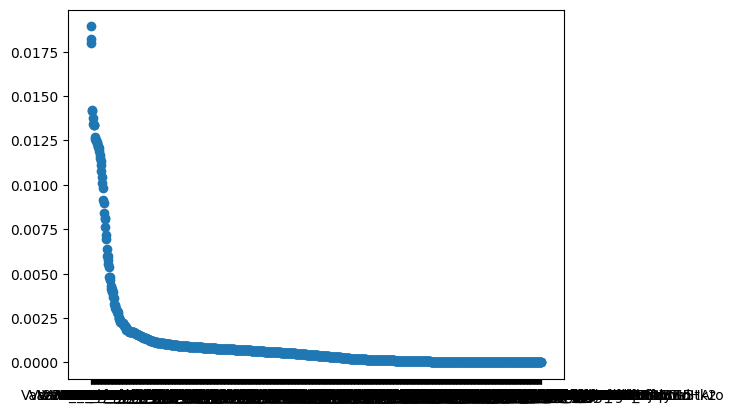

In [47]:
plt.scatter(x=variables, y=importances)

In [48]:
def sum_and_plot_importances(variables, importances):
    lista_coluna = dict()
    
    for i in range(importances.size):
        sum_importance = importances[:(i+1)].sum()
        this_variable = pd.Series([variables[i], sum_importance])
        lista_coluna.update({this_variable[0]: [this_variable[1]]})
    sum_importances = pd.DataFrame(lista_coluna).T.reset_index()
    sum_importances.columns = ['variaveis', 'valores']
    plt.scatter(sum_importances.index, sum_importances.iloc[:,1])
    return sum_importances

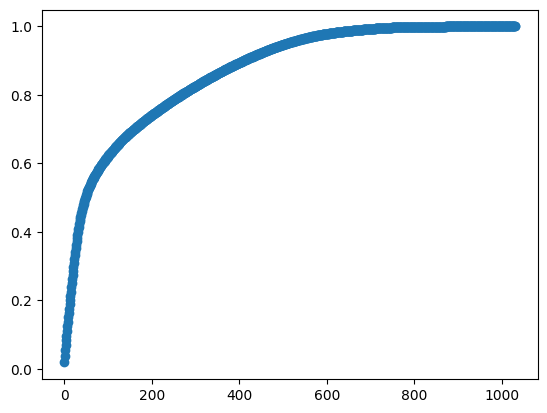

In [49]:
sum_importances = sum_and_plot_importances(variables, importances)

In [50]:
sum_importances

,variaveis,valores
0,Var57,0.018927
1,Var73,0.037161
2,Var113,0.055166
3,Var153,0.069354
4,Var81,0.083512
...,...,...
1026,Var197_VPX5,1.000000
1027,Var197_bkoB,1.000000
1028,Var197_kOrz,1.000000
1029,Var197_sPdS,1.000000


In [51]:
def keep_vars(features, sum_importances, threshold):
    keep_vars = sum_importances[sum_importances['valores'] <= threshold]['variaveis']
    
    features = features.loc[:, keep_vars]
    return features

In [52]:
features_c = keep_vars(features_c, sum_importances, threshold=0.99)

In [53]:
features_c

,Var57,Var73,Var113,Var153,Var81,Var133,Var38,Var28,Var76,Var134,Var6,Var123,Var119,Var22,Var163,Var21,Var160,Var25,Var112,Var149,Var83,Var85,Var109,Var125,Var24,Var13,Var144,Var140,Var7,Var65,Var74,Var205_VpdQ,Var218_cJvF,Var218_missing,Var205_sJzTlal,Var211_Mtgm,Var132,Var219_FzaX,Var197_lK27,Var206_IYzP,Var197_TyGl,Var223_jySVZNlOJy,Var197_487l,Var35,Var78,Var197_JLbT,Var226_FSa2,Var219_missing,Var223_missing,Var181,Var197_0Xwj,Var206_zm5i,Var212_NhsEn4L,Var208_sBgB,Var226_Qu4f,Var226_WqMG,Var206_sYC_,Var197_ssAy,Var228_F2FyR07IdsN7I,Var193_RO12,Var205_missing,Var223_M_8D,Var210_uKAI,Var203_HLqf,Var226_fKCe,Var210_g5HH,Var203_F3hy,Var226_Aoh3,Var226_szEZ,Var212_XfqtO3UdzaXh_,Var206_missing,Var226_453m,Var204_k13i,Var206_43pnToF,Var226_5Acm,Var226_7P5s,Var204_RVjC,Var226_xb3V,Var204_m_h1,Var226_Qcbd,Var219_qxDb,Var195_taul,Var204__xpN,Var206_hAFG,Var207_me75fM6ugJ,Var204_rGJy,Var206_wMei,Var226_PM2D,Var206_haYg,Var204_7WNq,Var226_uWr3,Var204_DtNL,Var226_rgKb,Var204_vzJD,Var204_z5Ry,Var204_MBhA,Var143,Var227_RAYp,Var197_z32l,Var44,Var204_15m3,Var219_AU8pNoi,Var204_e7QV,Var204_SkZj,Var221_oslk,Var226_TNEC,Var207_7M47J5GA0pTYIFxg5uy,Var204_mTeA,Var204_TjV7,Var228_55YFVY9,Var204_xQ2A,Var227_ZI9m,Var197_PGNs,Var204_4N0K,Var219_OFWH,Var196_z3mO,Var204_STGZ,Var226_Xa3G,Var204_X8zP,Var204_Y9Bl,Var204_YULl,Var226_7aLG,Var197_2Ix5,Var197_kNzO,Var204_Px52,Var226_kwS7,Var192_2jigUH7ejg,Var197_7gSz,Var197_4fje,Var192_missing,Var206_kxE9,Var204_RcM7,Var197_EJC9,Var204_t_4G,Var226_wX53,Var221_zCkv,Var197_PbOJ,Var204_LqKm,Var204_FbIm,Var192_oyGrjIXt5a,Var204__48V,Var206_Tkho,Var173,Var204_C6Eu,Var204_vm5R,Var192_kMJt0GoOh3,Var192_J9Vr4RQZiT,Var192_dRaTmBfHUn,Var206_6JmL,Var197_OTVu,Var195_LfvqpCtLOY,Var192_FoxgUHSK8h,Var193_AERks4l,Var197_wOc1,Var204_1Bp0,Var204_WGOH,Var204_6TCl,Var204_jdbz,Var197_AnrR,Var192_LDPvyx7IEC,Var204_TFSW,Var192_cFHt0GoOh3,Var206_lVqb,Var204_Z5OU,Var197_pGTb,Var207_DHn_WUyBhW_whjA88g9bvA64_,Var204_F_Lu,Var197_YVv3,Var192_DQlrEyXXnK,Var192_dRarjIK12c,Var204_qaiO,Var192_uUdt0G8EIb,Var192_dTGmfo8zhV,Var192_Foxt0Go8Lb,Var192_NQ5vyxLkBI,Var192_zC_Wq6e2Rv,Var197_LloI,Var192_qFpmfo8zhV,Var192_4e7gUH7IEC,Var226_me1d,Var197_TLkP,Var204_kJJ7,Var197_AHgj,Var192_8I1r4RXXnK,Var192_0vimfo8zhV,Var204_AKLO,Var192_oBXq9ayfAo,Var192_wRXmfo875g,Var226_7FJQ,Var197_hM6W,Var204_KubS,Var192_avkq9ayfAo,Var204_6Kw9,Var192_HYTrjIK12c,Var197_hAOr,Var197_tXti,Var204_0A_v,Var192_75lq9ayfAo,Var204_gnEy,Var192_2jiWq69cTy,Var204_iVbl,Var192_JMGq9aXt5a,Var192_xearjIX0Db,Var192_8Iqt0G8rTN,Var192_Yn7t0Go8Lb,Var204_MGOA,Var197_72yt,Var197_yMvB,Var192_ZSNrjIX0Db,Var197_Uk76,Var204_C7DI,Var192_LDPgUHXZeb,Var197_xgSF,Var192_DHegUHXZeb,Var192_639qrQK2Mx,Var192_ZSNq9aX0Db,Var204_xSqs,Var192_1YVgUHXZeb,Var192_NESWq69R_D,Var192_HrWq9aXt5a,Var192_NESt0G8EIb,Var219_AU8_WTd,Var192_dRagUHXM47,Var192_Iskvyx875g,Var197_vSNn,Var192_KXMrEyXXnK,Var192_9hRmfo875g,Var204_c2JP,Var192_Qu0r4RKzJV,Var197_uErj,Var219_wwPEXoilkr,Var228_ib5G6X1eUxUn6,Var197_0Y9G,Var197_UpNf,Var204_8BBI,Var192_EsYrjIX0Db,Var197_ujBx,Var192_51rt0G8rTN,Var192_lAFr4RQZiT,Var192_oBXTmBtFkL,Var227_6fzt,Var197_7ALb,Var204_QBpP,Var204_fTh6,Var197_AKN1,Var197_42Cy,Var192_vAsTmBfHUn,Var192_gE8Wq6edh4,Var197_LFM_,Var192_zcROj17IEC,Var192_hSogUHXZeb,Var204_iZJp,Var192_BQavyxLp3Z,Var204_yrDU,Var204_zfpA,Var192_IXSgUHShse,Var197_USOt,Var192_m9SrEy7Rm6,Var197_QQSE,Var204_EwzD,Var197_FPxv,Var192_KXMgUH7IEC,Var226_w_Ub,Var192_v0Nt0Go8Lb,Var192_Ie5gUH7IEC,Var204_YGOC,Var192_V8lt0G8rTN,Var192__v2gUHXZeb,Var192_tr0gUH7ejg,Var192_2jirEyXktW,Var204_H1uM,Var197_ZNsX,Var210_7A3j,Var204_wGwL,Var221_d0EEeJi,Var192_m9SvyxLkBI,Var192_vAsgUHXM47,Var192_2AAWq69R_D,Var197_dTod,Var192_HYTvyx7ejg,Var197_IvdZ,Var192_eOQgUHShse,Var197_oXaB,Var192_4bwt0GoOh3,Var192_hSovyx7IEC,Var192_TfiWq69R_D,Var197_GYbZ,Var197_dWQK,Var192_GcUt0G8rTN,Var197_wGW5,Var228_R4y5gQQWY8OodqDV,Var192_dRavyx7ejg,Var192_dRaq9ayE15,Var207_GjJ35utlTa_GNSvxxpb9ju,Var197_YFAj,Var192_Mtpt0G8EIb,Var212_CrNX,Var192_1KSr4RK2Mx,Var192_1fZWq6e2Rv,Var192_8I1TmBt

# Dividindo os dados em dataset para treino e teste

In [54]:
def split_datasets(features, outcome, test_size= 0.2):
    X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size= test_size, stratify=outcome,
                                                        random_state= 0)
    
    y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()
    return X_train, X_test, y_train, y_test

In [55]:
X_train, X_test, y_train, y_test = split_datasets(features_c, outcome)

In [56]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 673), (10000, 673), (40000,), (10000,))

# Modelagem preliminar

## Random Forest Classifier

In [57]:
def rfc_teste(x_train, y_train, n_estimators=100, cv= 5):
    np.random.seed(0)
    rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs=-1)
    cv_scores = cross_val_score(rfc, X_train, y_train, scoring='roc_auc', cv= cv, n_jobs=-1)
    print('Media dos cinco testes: ', cv_scores.mean())

In [58]:
rfc_teste(X_train,y_train)

Media dos cinco testes:  0.627501553901493


## Gradient Boosting Classifier

In [60]:
def gbc_teste(X_train, y_train, n_estimators=100, learning_rate=0.1, cv=5):
    np.random.seed(0)
    
    gbc = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=0)
    
    cv_scores = cross_val_score(gbc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    print(f'Media dos cinco testes: {cv_scores.mean()}')

In [61]:
gbc_teste(X_train, y_train)

Media dos cinco testes: 0.6710224202511523


## Otimizando o modelo GBC

### Otimizando n_estimators para learning_rate=0.1

In [62]:
def optimize(n_estimators, learning_rate, min_samples_split, min_samples_leaf, max_depth, max_features,
             subsample, params, cv=5):
    
    np.random.seed(0)
    
    gbc = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                                     min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,
                                     max_depth=max_depth, subsample=subsample, max_features=max_features)
    
    grid_search = GridSearchCV(estimator= gbc, param_grid= params, scoring='roc_auc', n_jobs=-1, cv=cv)
    grid_search.fit(X_train, y_train)
    results = grid_search.cv_results_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(best_params, best_score)

    return gbc, best_params, best_score

In [63]:
# Variaveis para coletar os resultados

models = np.array([])
opt_params = dict()
scores = np.array([])

In [64]:
# Modelo 0

learning_rate = 0.1
n_estimators = None
max_depth = 8
min_samples_split = 250
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'n_estimators': range(50,151,10)}

In [65]:
gbc, opt_param, score = optimize(n_estimators = n_estimators, learning_rate = learning_rate, 
                                 min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split, 
                                 max_depth = max_depth, subsample = subsample, max_features = max_features,
                                params = params)

{'n_estimators': 90} 0.6692647911317227


In [66]:
# Atualizando as variáveis
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [67]:
models

array([GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                                  min_samples_leaf=20, min_samples_split=250,
                                  n_estimators=None, subsample=0.8)          ],
      dtype=object)

In [68]:
opt_params

{'n_estimators': 90}

In [69]:
scores

array([0.66926479])

### Otimizando max_deph e min_samples_split

In [70]:
# Modelo 1

n_estimators = opt_params['n_estimators']
max_depth = None
min_samples_leaf = 20
min_samples_split = None
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(3,12,2), 'min_samples_split': range(150,401,50)}

In [71]:
gbc, opt_param, score = optimize(n_estimators = n_estimators, learning_rate = learning_rate, 
                                 min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split, 
                                 max_depth = max_depth, subsample = subsample, max_features = max_features,
                                params = params)

{'max_depth': 5, 'min_samples_split': 300} 0.6720458086386725


In [72]:
# Atualizando as variáveis

models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [73]:
models

array([GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                                  min_samples_leaf=20, min_samples_split=250,
                                  n_estimators=None, subsample=0.8)          ,
       GradientBoostingClassifier(max_depth=None, max_features='sqrt',
                                  min_samples_leaf=20, min_samples_split=None,
                                  n_estimators=90, subsample=0.8)             ],
      dtype=object)

In [74]:
opt_params

{'n_estimators': 90, 'max_depth': 5, 'min_samples_split': 300}

In [75]:
scores

array([0.66926479, 0.67204581])

### Otimizando o min_samples_leaf

In [76]:
# Modelo 2

n_estimators = opt_params['n_estimators']
max_depth = opt_params['max_depth']
min_samples_leaf = None
min_samples_split = opt_params['min_samples_split']
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(25,61,5)}

In [77]:
gbc, opt_param, score = optimize(n_estimators = n_estimators, learning_rate = learning_rate, 
                                 min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split, 
                                 max_depth = max_depth, subsample = subsample, max_features = max_features,
                                params = params)

{'min_samples_leaf': 30} 0.6711330899935968


In [78]:
# Atualizando as variáveis

models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [79]:
models

array([GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                                  min_samples_leaf=20, min_samples_split=250,
                                  n_estimators=None, subsample=0.8)          ,
       GradientBoostingClassifier(max_depth=None, max_features='sqrt',
                                  min_samples_leaf=20, min_samples_split=None,
                                  n_estimators=90, subsample=0.8)             ,
       GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                                  min_samples_leaf=None, min_samples_split=300,
                                  n_estimators=90, subsample=0.8)              ],
      dtype=object)

In [80]:
opt_params

{'n_estimators': 90,
 'max_depth': 5,
 'min_samples_split': 300,
 'min_samples_leaf': 30}

In [81]:
scores

array([0.66926479, 0.67204581, 0.67113309])

### Otimizando o max_features

In [82]:
# Modelo 3

n_estimators = opt_params['n_estimators']
max_depth = opt_params['max_depth']
min_samples_leaf = opt_params['min_samples_leaf']
min_samples_split = opt_params['min_samples_split']
max_features = None
subsample = 0.8
params = {'max_features': range(21,31,1)}

In [83]:
gbc, opt_param, score = optimize(n_estimators = n_estimators, learning_rate = learning_rate, 
                                 min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split, 
                                 max_depth = max_depth, subsample = subsample, max_features = max_features,
                                params = params)

{'max_features': 28} 0.6723361020914683


In [84]:
# Atualizando as variáveis

models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [85]:
models

array([GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                                  min_samples_leaf=20, min_samples_split=250,
                                  n_estimators=None, subsample=0.8)          ,
       GradientBoostingClassifier(max_depth=None, max_features='sqrt',
                                  min_samples_leaf=20, min_samples_split=None,
                                  n_estimators=90, subsample=0.8)             ,
       GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                                  min_samples_leaf=None, min_samples_split=300,
                                  n_estimators=90, subsample=0.8)              ,
       GradientBoostingClassifier(max_depth=5, min_samples_leaf=30,
                                  min_samples_split=300, n_estimators=90,
                                  subsample=0.8)                         ],
      dtype=object)

In [86]:
opt_params

{'n_estimators': 90,
 'max_depth': 5,
 'min_samples_split': 300,
 'min_samples_leaf': 30,
 'max_features': 28}

In [87]:
scores

array([0.66926479, 0.67204581, 0.67113309, 0.6723361 ])

### Otimizando o subsamples

In [88]:
# Modelo 4

n_estimators = opt_params['n_estimators']
max_depth = opt_params['max_depth']
min_samples_leaf = opt_params['min_samples_leaf']
min_samples_split = opt_params['min_samples_split']
max_features = opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

In [89]:
gbc, opt_param, score = optimize(n_estimators = n_estimators, learning_rate = learning_rate, 
                                 min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split, 
                                 max_depth = max_depth, subsample = subsample, max_features = max_features,
                                params = params)

{'subsample': 1.0} 0.6725963762262559


In [90]:
# Atualizando as variáveis

models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [91]:
models

array([GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                                  min_samples_leaf=20, min_samples_split=250,
                                  n_estimators=None, subsample=0.8)          ,
       GradientBoostingClassifier(max_depth=None, max_features='sqrt',
                                  min_samples_leaf=20, min_samples_split=None,
                                  n_estimators=90, subsample=0.8)             ,
       GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                                  min_samples_leaf=None, min_samples_split=300,
                                  n_estimators=90, subsample=0.8)              ,
       GradientBoostingClassifier(max_depth=5, min_samples_leaf=30,
                                  min_samples_split=300, n_estimators=90,
                                  subsample=0.8)                         ,
       GradientBoostingClassifier(max_depth=5, max_features=28, min_samples_leaf=30,
              

In [92]:
opt_params

{'n_estimators': 90,
 'max_depth': 5,
 'min_samples_split': 300,
 'min_samples_leaf': 30,
 'max_features': 28,
 'subsample': 1.0}

In [93]:
scores

array([0.66926479, 0.67204581, 0.67113309, 0.6723361 , 0.67259638])

### otimizando n_estimators e learning_rate

In [94]:
def optimize2(n_estimators, learning_rate, min_samples_split, min_samples_leaf, max_depth, max_features,
             subsample, cv=5):
    
    np.random.seed(0)
    
    gbc = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                                     min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,
                                     max_depth=max_depth, subsample=subsample, max_features=max_features, random_state=0)
    
    cv_scores = cross_val_score(gbc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = cv_scores.mean()
    plt.plot(np.append(scores, score))
    plt.title(f'N_estimators = {n_estimators} / learning rate= {learning_rate}')
    
    return gbc, score

In [95]:
learning_rate = 0.1
n_estimators = opt_params['n_estimators']

In [96]:
# Modelo 5

subsample = opt_params['subsample']
learning_rate /= 2
n_estimators *= 2

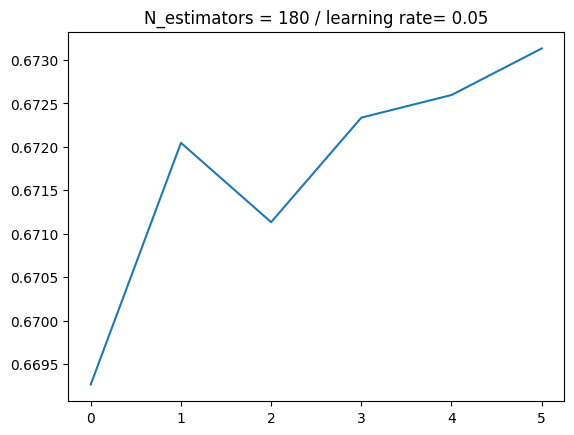

In [97]:
gbc, score = optimize2(n_estimators = n_estimators, learning_rate = learning_rate, 
                                 min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split, 
                                 max_depth = max_depth, subsample = subsample, max_features = max_features)

In [98]:
scores

array([0.66926479, 0.67204581, 0.67113309, 0.6723361 , 0.67259638])

In [99]:
score

0.6731320926161282

In [100]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

In [101]:
scores

array([0.66926479, 0.67204581, 0.67113309, 0.6723361 , 0.67259638,
       0.67313209])

In [102]:
# Modelo 6

learning_rate /= 7
n_estimators *= 7

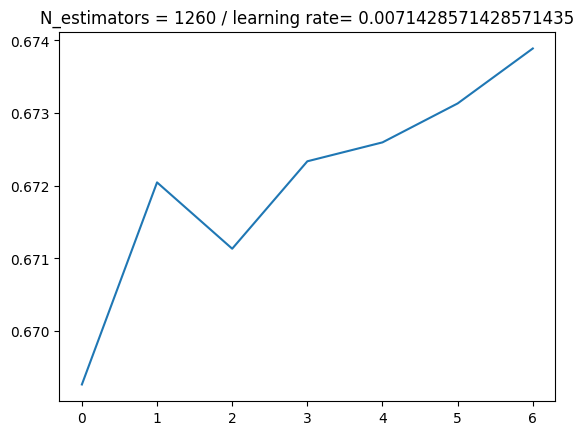

In [103]:
gbc, score = optimize2(n_estimators = n_estimators, learning_rate = learning_rate, 
                                 min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split, 
                                 max_depth = max_depth, subsample = subsample, max_features = max_features)

In [104]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

In [105]:
models

array([GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                                  min_samples_leaf=20, min_samples_split=250,
                                  n_estimators=None, subsample=0.8)          ,
       GradientBoostingClassifier(max_depth=None, max_features='sqrt',
                                  min_samples_leaf=20, min_samples_split=None,
                                  n_estimators=90, subsample=0.8)             ,
       GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                                  min_samples_leaf=None, min_samples_split=300,
                                  n_estimators=90, subsample=0.8)              ,
       GradientBoostingClassifier(max_depth=5, min_samples_leaf=30,
                                  min_samples_split=300, n_estimators=90,
                                  subsample=0.8)                         ,
       GradientBoostingClassifier(max_depth=5, max_features=28, min_samples_leaf=30,
              

In [106]:
scores

array([0.66926479, 0.67204581, 0.67113309, 0.6723361 , 0.67259638,
       0.67313209, 0.67388842])

In [107]:
# Modelo 7

learning_rate /= 2
n_estimators *= 2
learning_rate, n_estimators

(0.0035714285714285718, 2520)

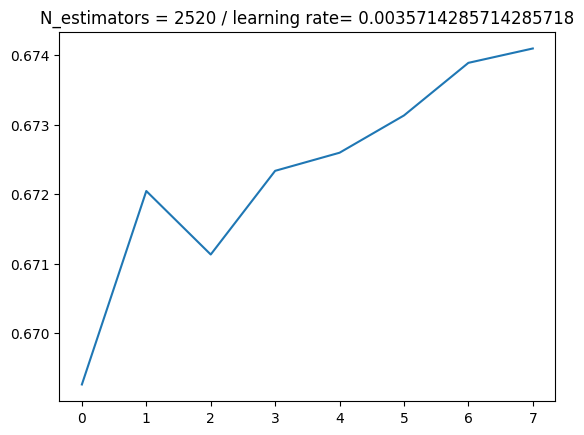

In [108]:
gbc, score = optimize2(n_estimators = n_estimators, learning_rate = learning_rate, 
                                 min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split, 
                                 max_depth = max_depth, subsample = subsample, max_features = max_features)

In [110]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

In [111]:
models

array([GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                                  min_samples_leaf=20, min_samples_split=250,
                                  n_estimators=None, subsample=0.8)          ,
       GradientBoostingClassifier(max_depth=None, max_features='sqrt',
                                  min_samples_leaf=20, min_samples_split=None,
                                  n_estimators=90, subsample=0.8)             ,
       GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                                  min_samples_leaf=None, min_samples_split=300,
                                  n_estimators=90, subsample=0.8)              ,
       GradientBoostingClassifier(max_depth=5, min_samples_leaf=30,
                                  min_samples_split=300, n_estimators=90,
                                  subsample=0.8)                         ,
       GradientBoostingClassifier(max_depth=5, max_features=28, min_samples_leaf=30,
              

In [112]:
scores

array([0.66926479, 0.67204581, 0.67113309, 0.6723361 , 0.67259638,
       0.67313209, 0.67388842, 0.67409496, 0.67409496])

In [113]:
# Modelo 8

learning_rate /= 5
n_estimators *= 5
learning_rate, n_estimators

(0.0007142857142857144, 12600)

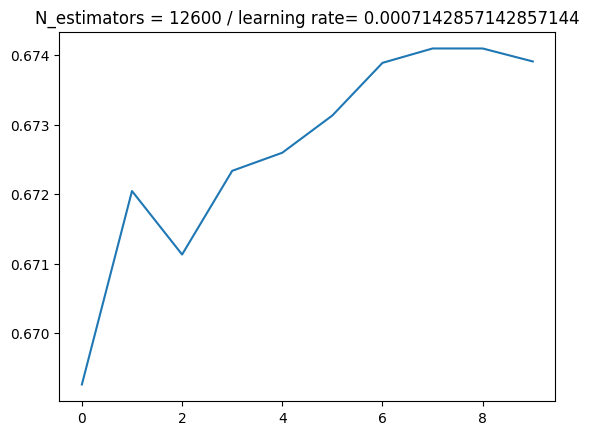

In [114]:
gbc, score = optimize2(n_estimators = n_estimators, learning_rate = learning_rate, 
                                 min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split, 
                                 max_depth = max_depth, subsample = subsample, max_features = max_features)

In [115]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

In [117]:
scores

array([0.66926479, 0.67204581, 0.67113309, 0.6723361 , 0.67259638,
       0.67313209, 0.67388842, 0.67409496, 0.67409496, 0.67390854])

In [116]:
print(f'Modelo de melhor desempenho: {scores.argmax()} - auc: {max(scores)}')

Modelo de melhor desempenho: 7 - auc: 0.674094956062223


In [118]:
best_model = models[scores.argmax()]
best_model

GradientBoostingClassifier(learning_rate=0.0035714285714285718, max_depth=5,
                           max_features=28, min_samples_leaf=30,
                           min_samples_split=300, n_estimators=2520,
                           random_state=0)

In [119]:
best_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.0035714285714285718, max_depth=5,
                           max_features=28, min_samples_leaf=30,
                           min_samples_split=300, n_estimators=2520,
                           random_state=0)

In [120]:
y_pred_probs = best_model.predict_proba(X_test)

In [121]:
y_pred_probs

array([[0.84241459, 0.15758541],
       [0.96664233, 0.03335767],
       [0.94790326, 0.05209674],
       ...,
       [0.93206125, 0.06793875],
       [0.93908433, 0.06091567],
       [0.87261437, 0.12738563]])

In [123]:
roc_auc_score(y_test, y_pred_probs[:, 1])

0.6851608323418481

In [124]:
roc_auc_score(y_test, y_pred_probs[:, 0])

0.31483916765815195

## Resultados KDD Cup 2009

https://www.kdd.org/kdd-cup/view/kdd-cup-2009/Results

## Conclusões

> Nesse exercício, foi possível modelar a possibilidade do cancelamento da conta com uma área sob a curva (AUC) de 0.6868

> É bom lembrar que AUC = 0.5 indica a linha de base, no caso de um modelo que faz predições aleatórias, e AUC = 1.0 indica um modelo ideal, que faz predições perfeitas

> Pode parecer que o AUC alcançado não é muito alto, mas também temos que considerar que o score mais alto no desafio público foi de 0.76

> Isso indica que, muito possivelmente, os dados fornecidos não são suficientes para fazer a modelagem perfeita do cancelamento da conta, e isso é sempre algo que devemos levar em consideração quando estamos tentando desenvolver modelos para problemas que não temos qualquer conhecimento prévio

> Fazendo uma analogia simples, seria como tentar predizer o peso de uma pessoa usando uma base de dados com apenas peso e altura de uma população: nós até conseguiríamos uma resposta razoável, já que as duas variáveis são correlacionadas, mas ela não seria perfeita simplesmente porque mais variáveis têm impacto no peso além da altura. É possível, portanto, que o maior score indique o melhor modelo que esses dados são capazes de fornecer

> Também devemos nos lembrar de que esses desafios geralmente são lançados sem que exista uma resposta prévia, eles servem justamente para que a própria comunidade tente encontrar soluções e comparar seus resultados entre si, e não com um "padrão ouro" ou a "resposta certa".